In [ ]:
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [ ]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
pos_path=os.path.join('data','positive')
neg_path=os.path.join('data','negative')
anc_path=os.path.join('data','anchor')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xf /content/drive/MyDrive/data.tar

In [ ]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

In [ ]:
for directory in os.listdir('lfw'):
  for file in os.listdir(os.path.join('lfw',directory)):
    ex_path=os.path.join('lfw',directory,file)
    new_path=os.path.join(neg_path, file)
    os.replace(ex_path, new_path)

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  frame=cv2.flip(frame,1)
  frame=frame[120:370,200:450,:]

  if cv2.waitKey(1) & 0XFF==ord('a'):
    imgname=os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)
  if cv2.waitKey(1) & 0XFF==ord('p'):
    imgname=os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
    cv2.imwrite(imgname, frame)

  cv2.imshow("Image Collection", frame)

  if cv2.waitKey(1) & 0XFF==ord('q'):
    break
cap.release()
cv2.destroyAllWindows()

In [ ]:
anchor=data.Dataset.list_files(os.path.join(anc_path ,'*.jpg')).take(300)
positive=data.Dataset.list_files(os.path.join(pos_path,'*.jpg')).take(300)
negative=data.Dataset.list_files(os.path.join(neg_path,'*.jpg')).take(300)

In [ ]:
def preprocess(file_path):
  byte_img=tf.io.read_file(file_path)
  img=tf.io.decode_jpeg(byte_img)
  img=tf.image.resize(img,(105,105))
  img=img/255.0
  return img

In [ ]:
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data=positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
data=data.map(preprocess_twin)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [ ]:
train_data=data.take(round(len(data)*0.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [ ]:
test_data=data.skip(round(len(data)*0.7))
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [ ]:
def make_embedding():
  inp=Input(shape=(105,105,3), name='input_image')

  c1=Conv2D(64, (10,10), activation='relu')(inp)
  m1=MaxPooling2D(64, (2,2), padding='same')(c1)

  c2=Conv2D(128, (7,7), activation='relu')(m1)
  m2=MaxPooling2D(64, (2,2), padding='same')(c2)

  c3=Conv2D(128, (4,4), activation='relu')(m2)
  m3=MaxPooling2D(64, (2,2), padding='same')(c3)

  c4=Conv2D(256, (4,4), activation='relu')(m3)
  f1=Flatten()(c4)
  d1=Dense(4096, activation='sigmoid')(f1)

  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 105, 105, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class L1Dist(Layer):
  def __init__(self, **kwargs):
    super().__init__()
  def call(self, input_embedding, validation_embedding):
    return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
def make_siamese_model():
  input_img=Input(name="input_image", shape=(105,105,3))
  validation_img=Input(name="validation_image", shape=(105,105,3))

  siamese_layer = L1Dist()
  inp_embedding = embedding(input_img)
  val_embedding = embedding(validation_img)
  distances = siamese_layer(embedding(input_img)[0], embedding(validation_img)[0])
  classifier = Dense(1, activation='sigmoid')(distances)
  return Model(inputs=[input_img, validation_img], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model=make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 105, 105, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_image          │ (None, 105, 105, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,960,448 │ input_image[0][0],     │
│                           │                        │                │ validation_image[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_3 (L1Dist)        │ (None, 4096)           │              0 │ embedding[12][0],      │
│                           │                        │                │ embedding[13][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir='./training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):

  with tf.GradientTape() as tape:
    X=batch[:2]
    y=batch[2]

    yhat=siamese_model(X, training=True)
    loss=binary_cross_loss(y, yhat)

  grad=tape.gradient(loss, siamese_model.trainable_variables)
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

  return loss

In [ ]:
def train(data, EPOCHS):
  for epoch in range(1, EPOCHS+1):
    print('\n Epoch{}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(len(data))

    for idx, batch in enumerate(data):
      train_step(batch)
      progbar.update(idx+1)

    if epoch%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS=50

In [ ]:
train(train_data, EPOCHS)


 Epoch1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step

 Epoch2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

 Epoch3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step

 Epoch5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

 Epoch6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step

 Epoch7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step

 Epoch8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step

 Epoch9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step

 Epoch10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step

 Epoch11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step

 Epoch12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step

 Epoch13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step

 Epoch14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step

 Epoch18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step

 Epoch19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
yhat=siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
res=[]
for prediction in yhat:
  if prediction > 0.5:
    res.append(1)
  else:
    res.append(0)
yhat=np.array(res)

In [ ]:
m=Recall()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

In [ ]:
m=Precision()
m.update_state(y_true, yhat)
m.result().numpy()

1.0

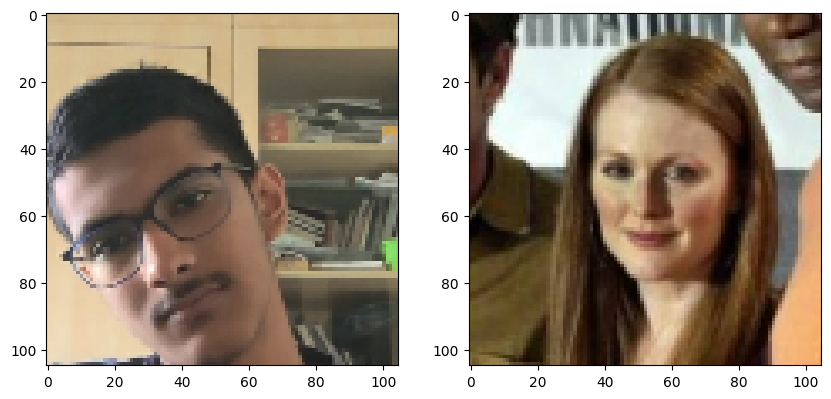

In [ ]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [ ]:
siamese_model.save('siamesemodel.keras')

In [ ]:
model=tf.keras.models.load_model('siamesemodel.keras',
                                 custom_objects={L1Dist:'L1Dist', 'BinaryCrossEntropy':tf.losses.BinaryCrossEntropy})

In [ ]:
def verify(model, detection_threshold, verification_threshold):
  results=[]
  for image in os.listdir(os.path.join('application_data','varification_images')):
    input_img = preprocess(os.path.join('application_data','input_image', 'input_image.jpg'))
    validation_img = preprocess(os.path.join('application_data','varification_images', image))

    result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
    results.append(result)

  detection = np.sum(np.array(results) > detection_threshold)

  verification = detection / len(os.listdir(os.path.join('application_data','varification_images')))
  verified = verification > verification_threshold

  return results, verified

In [ ]:
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()
  frame=cv2.flip(frame,1)
  frame=frame[120:370,200:450,:]

  cv2.imshow("Verification", frame)

  if cv2.waitKey(10) & 0XFF==ord('v'):
    cv2.imwrite(os.path.join('application_data','input_image', 'input_image.jpg'), frame)

  results, verified = verify(model, 0.5, 0.5)
  print(verified)

  if cv2.waitKey(10) & 0XFF==ord('q'):
    break
cap.release()
cv2.destroyAllWindows()